# Tutorial 10 - Clustering

### Lecture and Tutorial Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:

* Describe a case where clustering would be an appropriate tool, and what insight it would bring from the data.
* Explain the k-means clustering algorithm.
* Interpret the output of a k-means cluster analysis.
* Perform k-means clustering in R using `k-means`
* Visualize the output of k-means clustering in R using a coloured scatter plot 
* Identify when it is necessary to scale variables before clustering and do this using R
* Use the elbow method to choose the number of clusters for k-means
* Describe advantages, limitations and assumptions of the kmeans clustering algorithm.

In [1]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(GGally)
library(broom)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Warning message:
“package ‘broom’ was built under R version 4.0.2”

Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is ma

# 1. Pokemon

We will be working with the Pokemon dataset from Kaggle, which can be found [here.](https://www.kaggle.com/abcsds/pokemon)
This dataset compiles the statistics on 721 Pokemon. The information in this dataset includes Pokemon name, type, health points, attack strength, defensive strength, speed points etc. These are values that apply to a Pokemon's abilities (higher values are better). We are interested in seeing if there are any sub-groups/clusters of pokemon based on these statistics. And if so, how many sub-groups/clusters there are.

![](https://media.giphy.com/media/3oEduV4SOS9mmmIOkw/giphy.gif)

Source: https://media.giphy.com/media/3oEduV4SOS9mmmIOkw/giphy.gif


**Question 1.0**
<br> {points: 1}

Use `read_csv` to load `pokemon.csv` from the `data/` folder.

*Assign your answer to an object called `pm_data`.*

In [2]:
pm_data <- read_csv("data/pokemon.csv")
pm_data

Parsed with column specification:
cols(
  `#` = col_double(),
  Name = col_character(),
  `Type 1` = col_character(),
  `Type 2` = col_character(),
  Total = col_double(),
  HP = col_double(),
  Attack = col_double(),
  Defense = col_double(),
  `Sp. Atk` = col_double(),
  `Sp. Def` = col_double(),
  Speed = col_double(),
  Generation = col_double(),
  Legendary = col_logical()
)



#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,FALSE
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,FALSE
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,TRUE
720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,TRUE
721,Volcanion,Fire,Water,600,80,110,120,130,90,70,6,TRUE


In [3]:
test_1.0()

[1] "Success!"


**Question 1.1**
<br> {points: 1}

Create a matrix of plots using `ggpairs`, choosing columns 5 to 11 (or equivalently, columns `Total` to `Speed`) from `pm_data`. First use the `select` function to extract columns `"Total":"Speed"`, and then pass the resulting dataframe to `ggpairs` to plot.

*Assign your answer to an object called `pm_pairs`.*

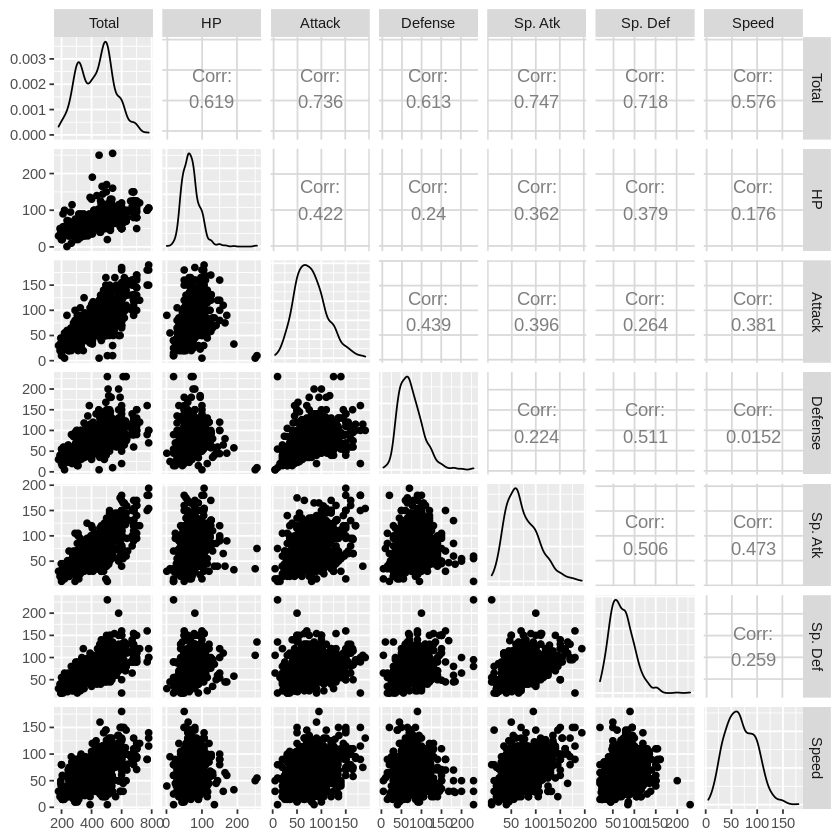

In [4]:
pm_pairs <- pm_data %>% select(Total:Speed) %>% ggpairs(columns = 1:7)

pm_pairs

In [5]:
test_1.1()

[1] "Success!"


**Question 1.2** 
<br> {points: 1}

Select the columns `Speed` and `Defense`, creating a new dataframe with only those columns.

*Assign your answer to an object named `km_data`.*

In [6]:
km_data <- pm_data %>% select(Speed, Defense)
km_data

Speed,Defense
<dbl>,<dbl>
45,49
60,63
80,83
⋮,⋮
70,60
80,60
70,120


In [7]:
test_1.2()

[1] "Success!"


**Question 1.3**
<br> {points: 1}

Make a scatterplot to visualize the relationship between `Speed` and `Defense` of the Pokemon. Put the `Speed` variable on the x-axis, and the `Defense` variable on the y-axis.

*Assign your plot to an object called `pm_scatter`. Don't forget to do everything needed to make an effective visualization.*

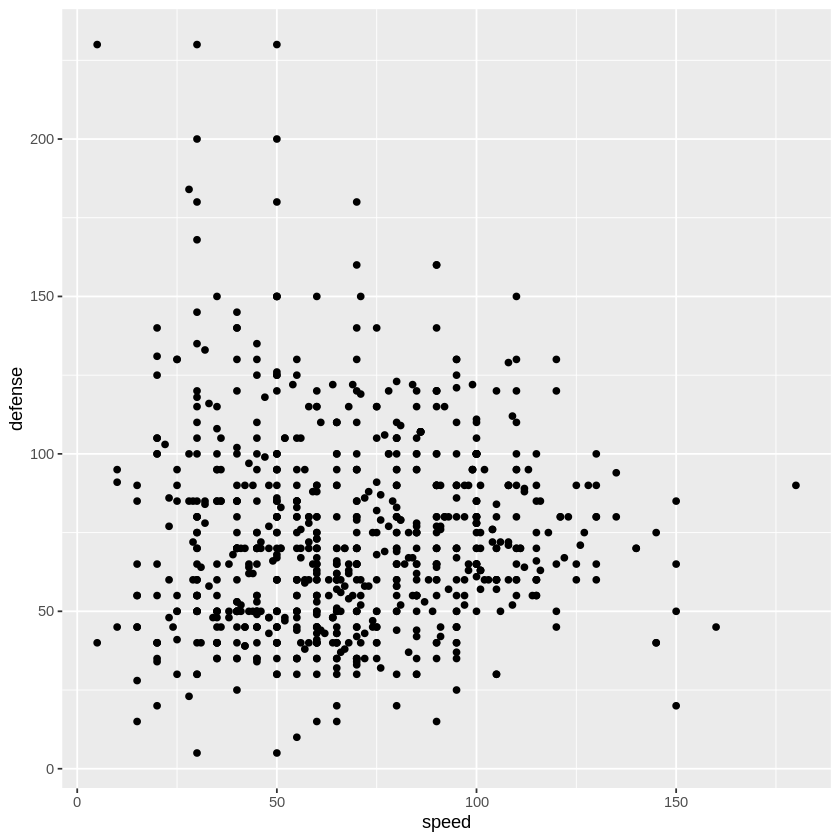

In [8]:
pm_scatter <- km_data %>% ggplot(aes(x = Speed, y = Defense)) +
    geom_point() +
    labs(x = "speed", y = "defense")
pm_scatter

In [9]:
test_1.3()

[1] "Success!"


**Question 1.4.1** 
<br> {points: 3}

We are going to cluster the Pokemon based on their `Speed` and `Defense`. Will it matter much for our clustering if we scale our variables? Is there any argument against scaling here?

**`Scaling the variables will influence the clustering most of the time, since the k-means clustering uses straight-line ditance. Speed and defense has different definitions and different units, so they should be scaled before clustering. But if there are two variables with same definitions and same units, we should not scale them, e.g. content of Na+ and content of Cl- in a solution (with same units).`**

**Question 1.4.2**
<br> {points: 1}

Now, let's use the `kmeans` function to cluster the Pokemon based on their `Speed` and `Defense` variables. For this question, use $k$ = 4. As good practice, let's standardize the data here first using `scale`. Name the standardized data `scaled_km_data`.

*Assign your answer to an object called `pokemon_clusters`.*

**Note:** We set the random seed here because `kmeans` initializes observations to random clusters.

In [10]:
#DON'T CHANGE THE SEED VALUE BELOW!
set.seed(2019)
scaled_km_data <- km_data %>% mutate(across(.cols = everything(), scale))

pokemon_clusters <- kmeans(km_data, center = 4)

pokemon_clusters

K-means clustering with 4 clusters of sizes 263, 178, 104, 255

Cluster means:
      Speed   Defense
1  53.10646  45.83270
2  46.56742  83.06742
3  64.43269 131.16346
4 100.64706  72.91373

Clustering vector:
  [1] 1 1 4 3 1 4 4 4 4 2 2 3 3 1 1 1 1 1 1 4 1 1 4 4 1 4 1 4 1 4 4 4 2 3 1 2 4
 [38] 1 1 4 1 2 1 4 1 1 1 4 1 2 2 1 2 1 4 1 4 1 4 1 4 1 4 1 4 4 4 2 1 4 4 4 1 2
 [75] 2 1 1 1 1 4 2 3 3 4 4 2 2 3 2 2 1 1 4 1 2 1 2 2 3 1 4 4 4 3 1 2 2 3 4 4 2
[112] 2 2 2 4 4 2 2 3 2 3 1 3 4 4 2 4 1 1 4 4 4 4 4 4 4 4 3 4 4 4 3 2 1 1 1 4 1
[149] 2 2 3 2 3 4 4 2 4 4 4 1 1 4 4 4 4 4 2 2 4 1 4 4 2 2 3 1 4 1 1 1 4 1 2 4 1
[186] 1 1 1 1 2 2 1 4 1 1 2 2 2 1 2 2 2 1 1 4 4 1 1 4 1 2 4 3 4 2 4 1 1 4 2 3 2
[223] 3 3 3 1 2 4 2 3 3 4 3 4 1 2 1 3 1 2 2 1 2 1 2 3 1 4 4 4 1 3 2 4 1 1 2 1 4
[260] 1 4 1 4 4 3 1 2 3 3 3 4 4 1 4 4 4 1 1 4 4 1 2 2 3 1 2 1 4 1 1 1 1 2 1 1 2
[297] 1 1 4 1 4 1 2 1 1 4 4 1 1 1 2 1 4 4 2 4 1 1 1 1 1 1 1 3 1 1 2 3 2 3 2 3 3
[334] 3 1 4 4 1 4 4 4 4 4 4 1 1 2 1 4 4 1 1 1 2 2 3 1 4 1 1 1 4 1 1 1 4

In [11]:
test_1.4.2()

[1] "Success!"


**Question 1.5**
<br> {points: 1}

Let's visualize the clusters we built in `pokemon_clusters`. For this we can use the `broom` package.

> "The broom package takes the messy output of built-in functions in R, such as lm, nls, or t.test, and turns them into tidy data frames." - [Broom Package](https://cran.r-project.org/web/packages/broom/vignettes/broom.html)

Your tasks:

1. Use the `augment` function create a data frame with the cluster assignments for each data point from k-means (should have the columns `Speed` and `Defense` and `.cluster`). 
2. Create a scatter plot of `Speed` (x-axis) vs `Defense` (y-axis) with the points coloured by their cluster assignment. 

Name this plot `answer1.5`.

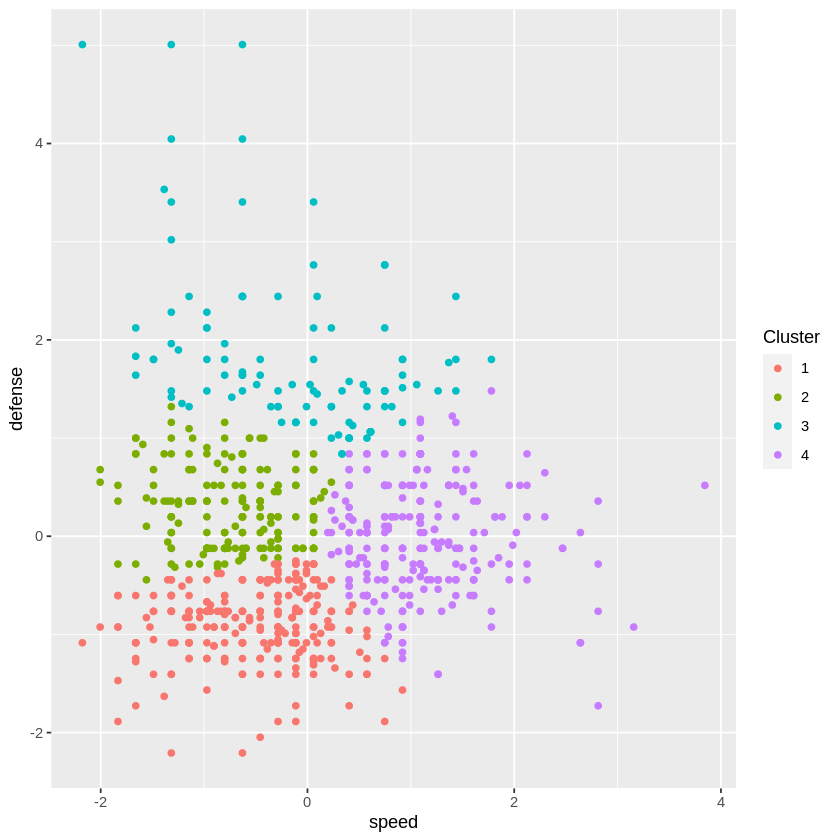

In [12]:
pokemon_clusters_new <- augment(pokemon_clusters, scaled_km_data)
answer1.5 <- pokemon_clusters_new %>% ggplot(aes(x = Speed, y = Defense)) +
    geom_point(aes(color = .cluster)) +
    labs(x = "speed", y = "defense", color = "Cluster")
answer1.5

In [13]:
test_1.5()

[1] "Success!"


**Question 1.6**
<br> {points: 3}

Below you can see multiple initializations of k-means with different seeds for `K = 4`. Can you explain what is happening and how we can mitigate this in the `kmeans` function?

![](imgs/multiple_initializations.png)

**`Setting a seed in R means to initialize a pseudorandom number generator. Different number of seed means different starting centroids of the clusters, which might lead to different clusters for several points and different colors. Selecting the same seed every time might mitigate this.`**

**Question 1.7**
<br> {points: 1}

We know that choosing a $k$ is an important step of the process. We can do this by examining how the total within-cluster sum of squares changes as we change $k$ on a plot (which we call an elbow plot).

For this exercise, from $k$ = 1 to $k$ = 10, you will calculate the total within-cluster sum of squares:

1. following good practice, make sure you are using the standardized data (`scaled_km_data`)
2. create a tibble with the $k$ values
3. create a new column `poke_clusts` by applying `kmeans` to each value of `k` (set `nstart` to be 10)
4. create a new column `glanced` by applying `glance` to each of the results
5. remove the `poke_clusts` column
6. `unnest` the results of `glance`


*Assign your answer to a tibble object named `elbow_stats`. It should have the columns `k`, `totss`, `tot.withinss`, `betweenss`, and `iter`.*

Remember, to acess the  total within-cluster sum of squares, you can use the `glance` function also from the `broom` package:

In [14]:
glance(pokemon_clusters)

totss,tot.withinss,betweenss,iter
<dbl>,<dbl>,<dbl>,<int>
1451721,475152.6,976567.9,3


In [32]:
set.seed(2020) # DO NOT REMOVE

k_value <- tibble("k" = 1:10)

km_clustering <- k_value %>%
    rowwise() %>%
    mutate(poke_clusts = list(kmeans(scaled_km_data, k, nstart = 10)))
km_glanced <- km_clustering %>% mutate(glanced = list(glance(poke_clusts)))

km_glanced <- km_glanced %>% select(-poke_clusts)

elbow_stats <- km_glanced %>% unnest(glanced)

elbow_stats

k,totss,tot.withinss,betweenss,iter
<int>,<dbl>,<dbl>,<dbl>,<int>
1,1598,1598.0000,2.046363e-12,1
2,1598,1031.4596,5.665404e+02,1
3,1598,640.4274,9.575726e+02,3
⋮,⋮,⋮,⋮,⋮
8,1598,269.9280,1328.072,4
9,1598,235.8644,1362.136,4
10,1598,214.3482,1383.652,6


In [16]:
test_1.7()

[1] "Success!"


**Question 1.8**
<br> {points: 1}

Create the elbow plot. Put the within-cluster sum of squares on the y-axis, and the number of clusters on the x-axis.

*Assign your plot to an object called `elbow_plot`*.

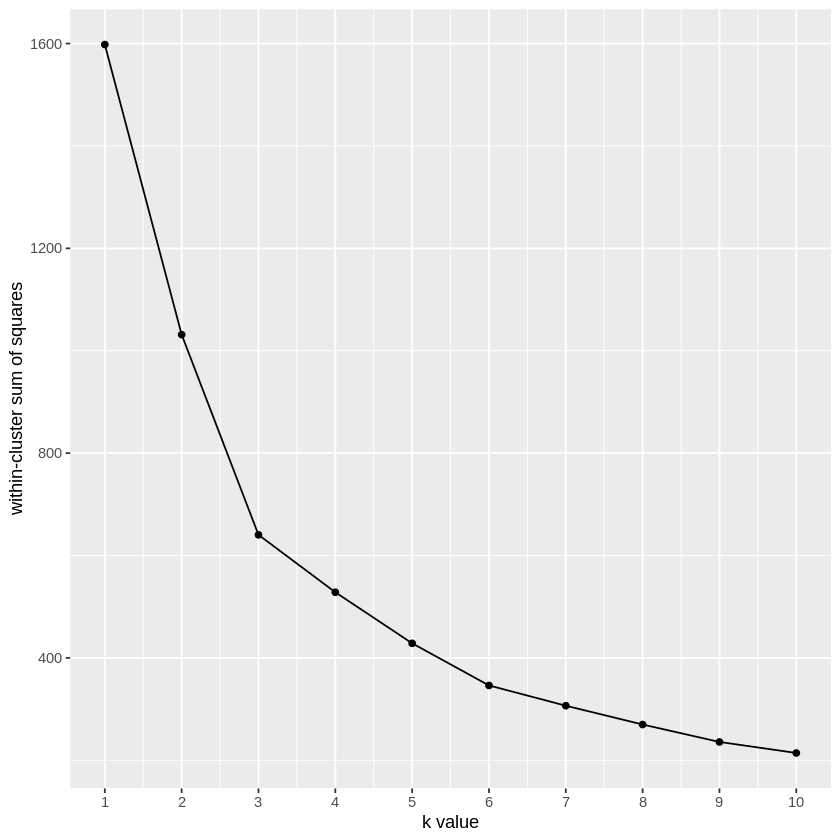

In [17]:
elbow_plot <- ggplot(elbow_stats, aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "k value", y = "within-cluster sum of squares") +
    scale_x_continuous(breaks = seq(1, 10, by = 1))
elbow_plot

In [18]:
test_1.8()

[1] "Success!"


**Question 1.9** 
<br> {points: 3}

Based on the elbow plot above, what value of $k$ do you choose? Explain why.

**`I chose 3 to be the value of k. This is because if k increases further than 3, the total within-cluster sum of squares will decrease for only a small amount.`**

**Question 1.10**
<br> {points: 3}

Using the value that you chose for k, perform the k-means algorithm, set `nstart = 10` and assign your answer to an object called `pokemon_final_kmeans`. 

Augment the data with the final cluster labels and assign your answer to an object called `pokemon_final_clusters`. 

Finally, create a plot called `pokemon_final_clusters_plot` to visualize the clusters. Include a title, colour the points by the cluster and make sure your axes are human-readable.

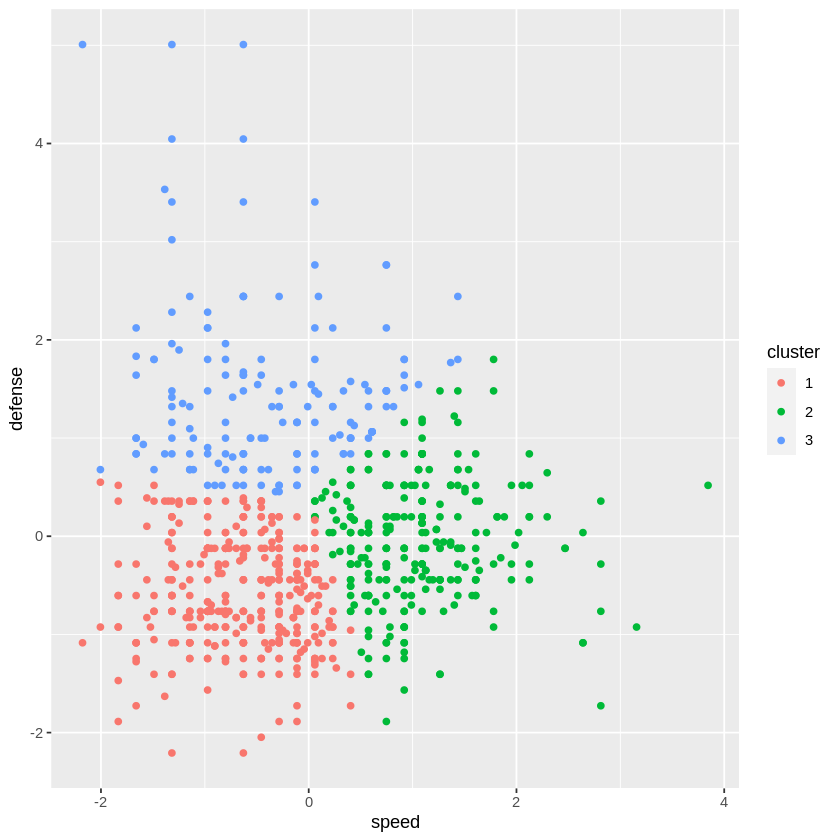

In [19]:
set.seed(2019) # DO NOT REMOVE
pokemon_final_kmeans <- kmeans(scaled_km_data, centers = 3, nstart = 10)
pokemon_final_clusters <- augment(pokemon_final_kmeans, scaled_km_data)
pokemon_final_clusters_plot <- ggplot(pokemon_final_clusters, aes(x = Speed, y = Defense)) +
    geom_point(aes(color = .cluster)) +
    labs(x = "speed", y = "defense", color = "cluster")
pokemon_final_clusters_plot

**Question 1.11**
<br> {points: 3}

Using `Speed` and `Defense`, we find some number of clusters in our data. However, we have more information in our dataset that might be useful for clustering. Let's incorporate all of the numeric values to our k-means model. Again use `nstart = 10`.

Your tasks:

1. Select the numeric type columns only from the full data set `pm_data`. For example, do not include the `#` or `Generation`  columns etc. Assign your answer to an object called `pm_multi`.
2. Standardize the columns in `pm_multi` using `scale`.
2. From K = 1 to K = 10, calculate the total within-cluster sum of squares. Set `nstart` to be 10. Assign your answer to an object called `pm_multi_elbow_stats`. 
3. Use the elbow plot method to determine the number of clusters. Assign your answer to an object called `pm_multi_elbow_plot`.
4. Train a k-means model with the number of clusters determined in above. Assign your answer to an object called `multi_kmeans`. 
5. Print the cluster means for the trained model.

In [20]:
#DON'T CHANGE THIS SEED VALUE
set.seed(2019)

pm_multi <- pm_data %>% select(Total:Speed)

scaled_pm_multi <- pm_multi %>% mutate(across(.cols = everything(), scale))

k <- tibble("k" = 1:10)

pm_multi_clustering <- k %>% rowwise() %>% mutate(models = list(kmeans(scaled_pm_multi, k, nstart = 10)))

pm_glanced <- pm_multi_clustering %>% mutate(glanced = list(glance(models)))

pm_selected <- pm_glanced %>% select(-models)

pm_multi_elbow_stats <- pm_selected %>% unnest(glanced)

pm_multi_elbow_plot <- pm_multi_elbow_stats %>%
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "k value", y = "total within-cluster sum of squares") +
    scale_x_continuous(breaks = seq(1, 10, by = 1))

k_value <- 2

multi_kmeans <- kmeans(scaled_pm_multi, centers = k_value, nstart = 10)

print(multi_kmeans)

K-means clustering with 2 clusters of sizes 378, 422

Cluster means:
       Total         HP     Attack    Defense    Sp. Atk    Sp. Def      Speed
1 -0.8838645 -0.5879347 -0.6374233 -0.5558041 -0.6170218 -0.6599417 -0.4969472
2  0.7917080  0.5266335  0.5709621  0.4978530  0.5526878  0.5911326  0.4451328

Clustering vector:
  [1] 1 1 2 2 1 1 2 2 2 1 1 2 2 1 1 1 1 1 1 2 1 1 2 2 1 1 1 2 1 2 1 2 1 2 1 1 2
 [38] 1 1 2 1 2 1 2 1 2 1 2 1 1 2 1 1 1 2 1 1 1 2 1 2 1 2 1 2 1 1 2 1 1 2 2 1 1
 [75] 2 1 1 2 1 2 1 1 2 1 2 1 2 2 1 2 1 1 2 1 2 1 2 1 2 1 1 2 2 1 1 2 1 2 1 2 1
[112] 2 1 1 2 2 1 1 2 1 2 2 1 2 2 1 2 1 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 1 1 2 2 2
[149] 1 1 2 1 2 2 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 1 1 2 1 1 2 1 1 1 2 1 1 1 1 2 1
[186] 2 1 1 1 1 1 1 2 1 1 2 2 2 1 1 1 2 1 1 2 1 1 2 1 1 2 2 2 1 2 2 1 1 2 1 2 1
[223] 1 2 2 1 2 1 2 2 2 2 2 1 1 2 1 1 1 2 1 1 2 1 2 2 1 2 2 2 1 2 2 2 1 1 2 1 1
[260] 1 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2
[297] 1 1 2 1 1 1 1 1 1 2 2 1 1 1 

**Question 1.12** 
<br> {points: 3}

Visualizing these clusters is not a simple task given the high-dimensionality of the model. But do the cluster means output help? Justify your reasoning.

**`We are able to show only 2 variables in a cluster plot one time. So it might be very complicated to do for all clusters. While with more variables used for clustering, the data above helps us to find the trends or characteristics of every cluster.`**

# 2. Tourism Reviews

![](https://media.giphy.com/media/xUNd9IsOQ4BSZPfnLG/giphy.gif)
Source: https://media.giphy.com/media/xUNd9IsOQ4BSZPfnLG/giphy.gif

The Ministry of Land, Infrastructure, Transport and Tourism of Japan is interested in knowing the type of tourists that visit East Asia. They know the [majority of their visitors come from this region](https://statistics.jnto.go.jp/en/graph/) and would like to stay competitive in the region to keep growing the tourism industry. For this, they have hired us to perform segmentation of the tourists. A [dataset from TripAdvisor](https://archive.ics.uci.edu/ml/datasets/Travel+Reviews) has been scraped and it's provided to you.

This dataset contains the following variables:

- User ID : Unique user id 
- Category 1 : Average user feedback on art galleries 
- Category 2 : Average user feedback on dance clubs 
- Category 3 : Average user feedback on juice bars 
- Category 4 : Average user feedback on restaurants 
- Category 5 : Average user feedback on museums 
- Category 6 : Average user feedback on resorts 
- Category 7 : Average user feedback on parks/picnic spots 
- Category 8 : Average user feedback on beaches 
- Category 9 : Average user feedback on theaters 
- Category 10 : Average user feedback on religious institutions

**Question 2.0**
<br> {points: 3}

Load the data set from https://archive.ics.uci.edu/ml/machine-learning-databases/00484/tripadvisor_review.csv and clean it so that only the Category # columns are in the data frame (i.e., remove the `User ID` column). 

Assign your answer to an object called `clean_reviews`.

In [21]:
clean_reviews <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00484/tripadvisor_review.csv")
clean_reviews

Parsed with column specification:
cols(
  `User ID` = col_character(),
  `Category 1` = col_double(),
  `Category 2` = col_double(),
  `Category 3` = col_double(),
  `Category 4` = col_double(),
  `Category 5` = col_double(),
  `Category 6` = col_double(),
  `Category 7` = col_double(),
  `Category 8` = col_double(),
  `Category 9` = col_double(),
  `Category 10` = col_double()
)



User ID,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
User 1,0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
User 2,1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
User 3,1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
User 978,0.61,1.32,0.67,0.43,1.30,1.78,3.17,2.81,1.34,3.02
User 979,0.93,0.20,0.13,0.43,0.30,0.40,3.18,2.98,1.12,2.46
User 980,0.93,0.56,1.13,0.51,1.34,2.36,3.18,2.87,1.34,2.40


In [22]:
test_that('Did not create an object called clean_reviews', {
    expect_true(exists("clean_reviews"))
})
# The remainder of the tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.


**Question 2.1**
<br> {points: 3}

Perform k-means and vary $k$ from 1 to 10 to identify the optimal number of clusters. Use `nstart = 100`. Assign your answer to a tibble object called `elbow_stats` that has the columns `k`, `totss`, `tot.withinss`, `betweenss`, and `iter`.  

Afterwards, create an elbow plot to help you choose $k$. Assign your answer to an object called `tourism_elbow_plot`.

Warning message:
“Problem with `mutate()` input `models`.
ℹ did not converge in 10 iterations
ℹ Input `models` is `list(kmeans(scaled_reviews, k, nstart = 100))`.
ℹ The error occurred in row 9.”
Warning message:
“did not converge in 10 iterations”
Warning message:
“Problem with `mutate()` input `models`.
ℹ did not converge in 10 iterations
ℹ Input `models` is `list(kmeans(scaled_reviews, k, nstart = 100))`.
ℹ The error occurred in row 10.”
Warning message:
“did not converge in 10 iterations”


k,totss,tot.withinss,betweenss,iter
<int>,<dbl>,<dbl>,<dbl>,<int>
1,9790,9790.000,-5.820766e-11,1
2,9790,7759.473,2.030527e+03,1
3,9790,7090.652,2.699348e+03,3
⋮,⋮,⋮,⋮,⋮
8,9790,5055.061,4734.939,6
9,9790,4841.624,4948.376,9
10,9790,4678.350,5111.650,6


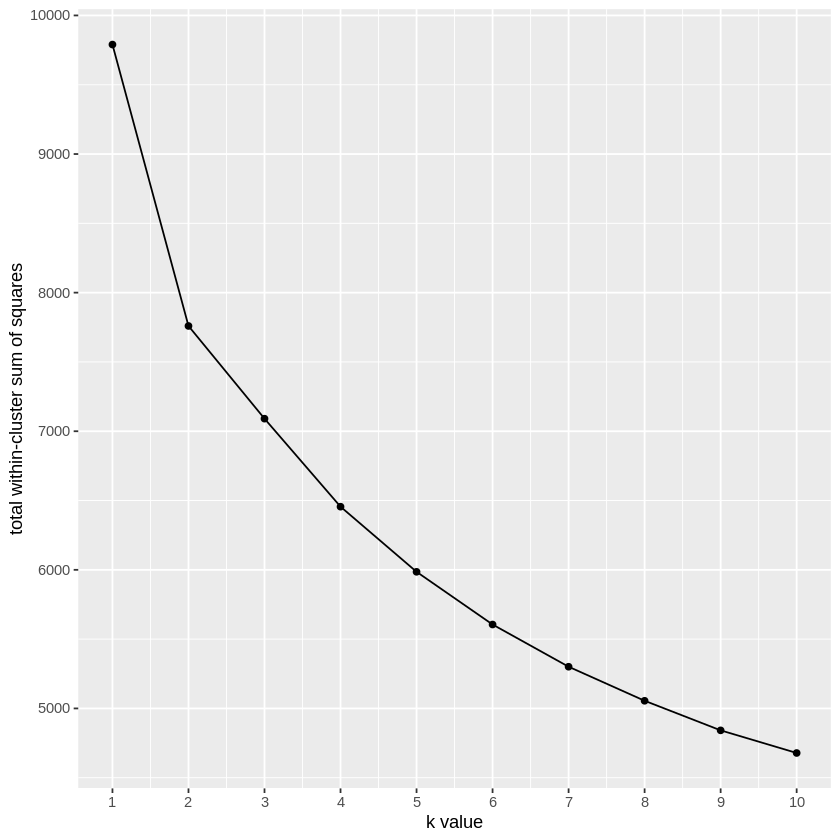

In [23]:
#DON'T CHANGE THIS SEED VALUE
set.seed(2019)

k <- tibble("k" = 1:10)

colnames(clean_reviews) <- make.names(colnames(clean_reviews))

scaled_reviews <- clean_reviews %>% select(-User.ID) %>% mutate(across(.cols = everything(), scale))

reviews_clustering <- k %>% rowwise() %>% mutate(models = list(kmeans(scaled_reviews, k, nstart = 100)))

reviews_glanced <- reviews_clustering %>% mutate(glanced = list(glance(models)))

reviews_selected <- reviews_glanced %>% select(-models)

elbow_stats <- reviews_selected %>% unnest(glanced)

elbow_stats

tourism_elbow_plot <- elbow_stats %>% ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "k value", y = "total within-cluster sum of squares") +
    scale_x_continuous(breaks = seq(1, 10, by = 1))

tourism_elbow_plot

In [24]:
test_that('Did not create an object called elbow_stats', {
    expect_true(exists('elbow_stats'))
})
test_that('Did not create a plot called tourism_elbow_plot', {
    expect_true(exists('tourism_elbow_plot'))
})
# The remainder of the tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.

**Question 2.2** 
<br> {points: 3}

From the elbow plot above, which $k$ should you choose? Explain why you chose that $k$.

**`I chose 2 to be the value of k. This is because if k increases further than 2, the total within-cluster sum of squares will be decrease for only a small amount.`**

**Question 2.3**
<br> {points: 3}

Run kmeans again, with the optimal $k$, and assign your answer to an object called `reviews_clusters`. Use `nstart = 100`. Then, use the `augment` function to get the cluster assignments for each point. Name the data frame `cluster_assignments`.

In [25]:
#DONT CHANGE THIS SEED VALUE
set.seed(2019)

reviews_clusters <- kmeans(scaled_reviews, centers = 2, nstart = 100)

cluster_assignments <- augment(reviews_clusters, scaled_reviews)

cluster_assignments

Category.1,Category.2,Category.3,Category.4,Category.5,Category.6,Category.7,Category.8,Category.9,Category.10,.cluster
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
0.1125872,0.9354094,1.6189231,0.312800143,-0.3194447,1.0696225,1.1580656,-0.3277049,0.6871667,-1.1799885,1
0.3878904,1.7717393,2.0881049,0.384297318,1.0979250,2.4782350,3.7141565,-1.4912948,0.7968671,-1.4911467,1
0.9996754,-1.1554154,-0.6001801,-0.008937147,-1.5996497,-0.5614024,-0.1199798,-0.2549805,-0.7115135,-0.9310618,2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
-0.8662688,-0.06818649,-0.4353324,-0.36642302,0.8235954,-0.1165774,-1.3980252,-0.1822562,-0.6292382,0.6869613,2
0.1125872,-2.40991027,-1.1200842,-0.36642302,-1.4624848,-2.6743211,-0.1199798,1.0540581,-1.2325904,-1.0555251,2
0.1125872,-1.65721334,0.1479747,-0.08043432,0.9150386,0.9584163,-0.1199798,0.2540900,-0.6292382,-1.2422201,1


For the following 2 questions use the following plot as reference. 

> The visualization below is a density plot, you can think of it as a smoothed version of a histogram. Density plots are more effective for comparing multiple distributions. What we are looking for with these visualizations, is to see which variables have difference distributions between the different clusters.

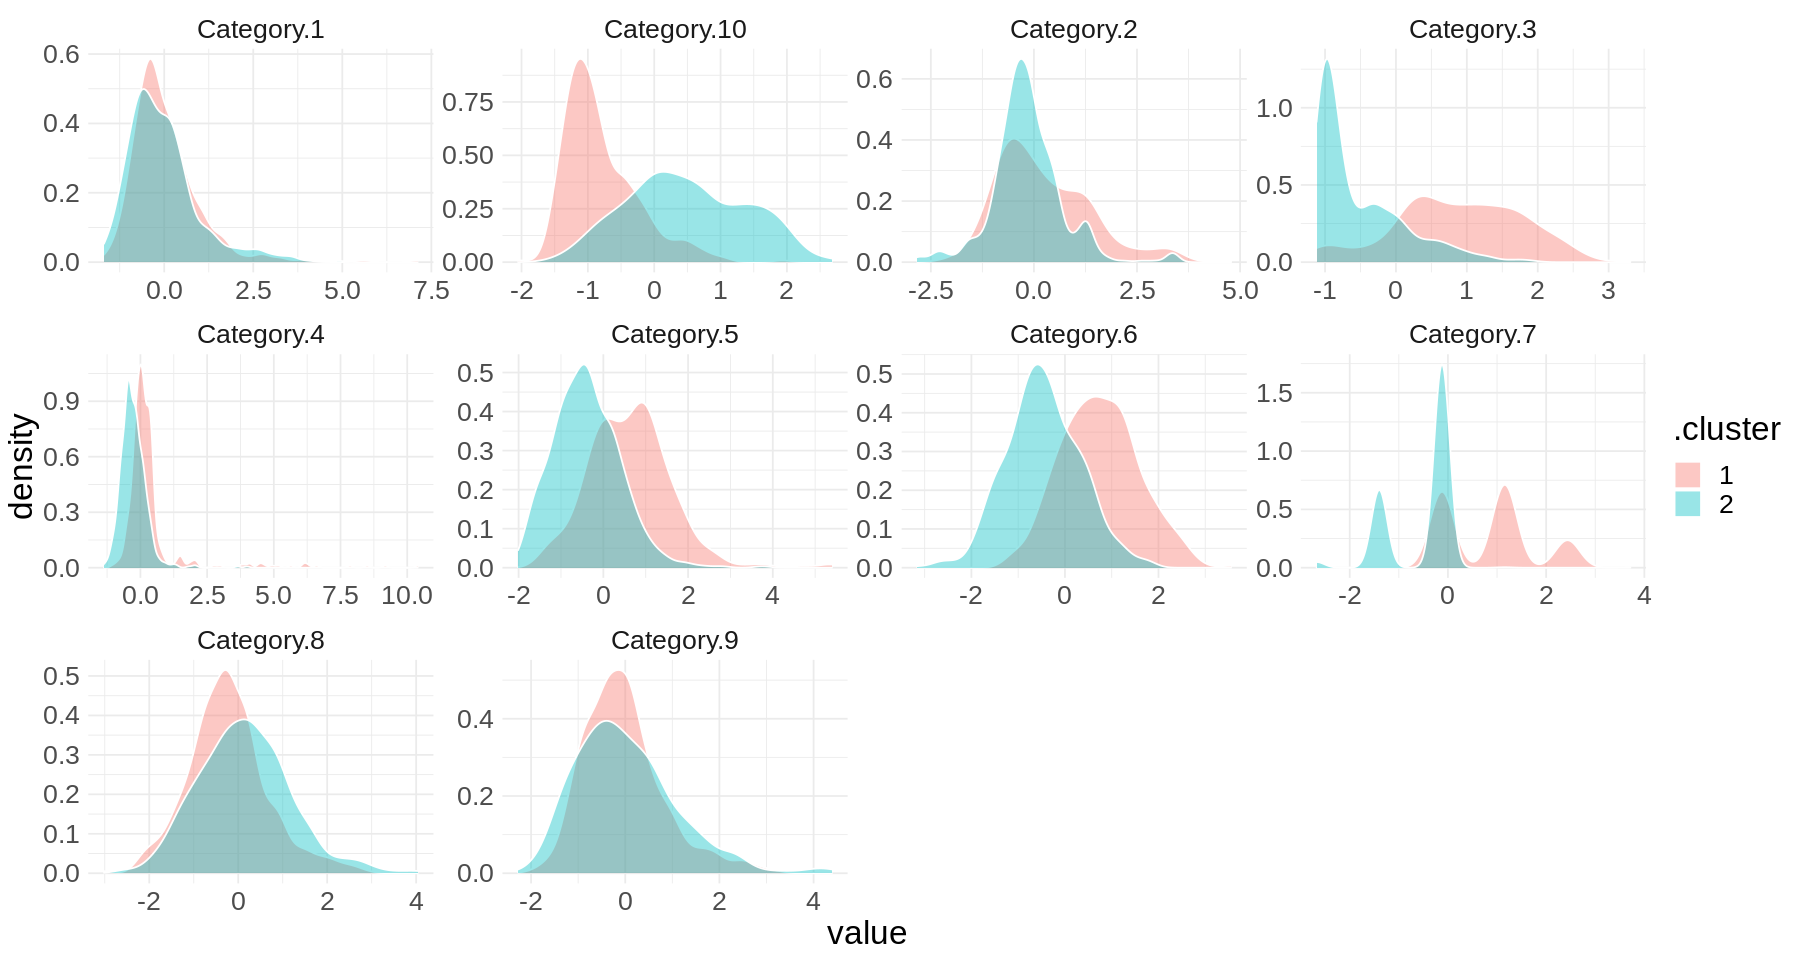

In [26]:
options(repr.plot.height = 8, repr.plot.width = 15)
cluster_assignments %>%
    pivot_longer(cols = -.cluster, names_to = 'category', values_to = 'value')  %>% 
    ggplot(aes(value, fill = .cluster)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(~ category, scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 20))

**Question 2.4** Multiple Choice:
<br> {points: 1}

From the plots above, point out the categories that we might hypothesize are driving the clustering? (i.e., are useful to distinguish between the type of tourists?) We list the table of the categories below. 

- Category 1 : Average user feedback on art galleries 
- Category 2 : Average user feedback on dance clubs 
- Category 3 : Average user feedback on juice bars 
- Category 4 : Average user feedback on restaurants 
- Category 5 : Average user feedback on museums 
- Category 6 : Average user feedback on resorts 
- Category 7 : Average user feedback on parks/picnic spots 
- Category 8 : Average user feedback on beaches 
- Category 9 : Average user feedback on theaters 
- Category 10 : Average user feedback on religious institutions

A. 10, 3, 5, 6, 7

B. 10, 3, 5, 6, 1

C. 10, 3, 4, 6, 7

D. 10, 2, 5, 6, 7

*Assign your answer to an object called `answer2.4`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [27]:
answer2.4 <- "A"
answer2.4

[1] "A"

In [28]:
test_that('Did not create an object called answer2.4', {
    expect_true(exists('answer2.4'))
    })
# The remainder of the tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.


**Question 2.5** 
<br> {points: 3}

Discuss one disadvantage of not being able to visualize the clusters when dealing with multidimensional data.

**`The answer will not be intuitive, so that people might accidentally make a mistake due to carelessness. And it is hard to show how much each variable drives the clustering.`**

In [29]:
source("cleanup.R")